In [39]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

sys.path.append("../front_end")

df_annotations = pd.read_csv("../data/ctgov/annotations/all_annotations.csv")


In [40]:
MODELS_DIR = '../front_end/models/'

In [41]:
from util.page_tokeniser import tokenise_pages

In [42]:
from processors.country_extractor import CountryExtractor, extract_features, LMIC_COUNTRIES

In [43]:
from processors.country_ensemble_extractor import make_feature_vector, FEATURES

In [44]:
from processors.country_group_extractor import CountryGroupExtractor

In [45]:
from processors.international_extractor_spacy import InternationalExtractorSpacy

In [46]:
from processors.international_extractor_naive_bayes import InternationalExtractorNaiveBayes

In [47]:
country_extractor = CountryExtractor()

In [48]:
country_group_extractor = CountryGroupExtractor(MODELS_DIR + "spacy-textcat-country-16-model-best")

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/protocols/lib/python3.10/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.2.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [49]:
international_extractor_spacy = InternationalExtractorSpacy(MODELS_DIR + "spacy-textcat-international-11-model-best")

In [50]:
international_extractor_naive_bayes = InternationalExtractorNaiveBayes(MODELS_DIR + "international_classifier.pkl.bz2")

Initialising int classifier ../front_end/models/international_classifier.pkl.bz2


/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/protocols/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/protocols/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/protocols/lib/python3.10/site-packages/sklear

In [51]:
df_small = df_annotations[(~df_annotations.country.isna())
                         
                         & (df_annotations.train_val == "val")]

In [52]:
#df_small = df_small.sample(100)

In [53]:
df_small.drop(columns=["num_arms", "num_subjects", "phase", "intervention_type", "has_sap"], inplace=True)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/protocols/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [54]:
from sklearn.model_selection import train_test_split
ids_train, ids_val = train_test_split(list(range(len(df_small))))
ids_train = set(ids_train)
ids_val = set(ids_val)

In [55]:
train_val = []
for idx in range(len(df_small)):
    if idx in ids_train:
        train_val.append("train")
    else:
        train_val.append("val")
df_small["train_val"] = train_val

/tmp/ipykernel_174887/1050101567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small["train_val"] = train_val


In [56]:
X = []
y = []
country_identities = []
files = []
train_val = []
for idx in range(len(df_small)):
    file_name = df_small.file.iloc[idx]
    
    with open("/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/data_open/read_ctgov_data/json/" + file_name + ".json", "r", encoding="utf-8") as f:
        pages = json.load(f)

    country_to_pages = country_extractor.process(pages)
    
    tokenised_pages = tokenise_pages(pages)
    
    country_group_to_pages = country_group_extractor.process(tokenised_pages)
        
    is_international_to_pages = international_extractor_spacy.process(tokenised_pages)
            
    is_international_nb_to_pages = international_extractor_naive_bayes.process(tokenised_pages)
    
    X_this_doc, country_identities_this_doc = make_feature_vector(country_to_pages["features"],
                                                        country_group_to_pages["probas"],
                                                        is_international_to_pages["probas"],
                                                        is_international_nb_to_pages["score"])
    
    all_country_identities_found = set(country_identities_this_doc)
    all_country_identities_gt = set(df_small.country.iloc[idx].split(","))
    
    is_extra_gt_not_found = False
    for c in all_country_identities_gt:
        if c not in all_country_identities_found:
            is_extra_gt_not_found = True
    
    for country_occurrence_idx in range(len(X_this_doc)):
        
        gt = int(country_identities_this_doc[country_occurrence_idx] in all_country_identities_gt)
        
        if country_identities_this_doc[country_occurrence_idx] == "XX" and is_extra_gt_not_found:
            gt = True
        
        X.append(X_this_doc[country_occurrence_idx])
        y.append(gt)
        country_identities.append(country_identities_this_doc[country_occurrence_idx])
        train_val.append(df_small.train_val.iloc[idx])
        files.append(df_small.file.iloc[idx])

In [57]:
X_train = []
y_train = []
X_val = []
y_val = []
countries_train = []
countries_val = []
file_names_train = []
file_names_val = []
for idx in range(len(X)):
    if train_val[idx] == "train":
        X_train.append(X[idx])
        y_train.append(y[idx])
        countries_train.append(country_identities[idx])
        file_names_train.append(files[idx])
    else:
        X_val.append(X[idx])
        y_val.append(y[idx])
        countries_val.append(country_identities[idx])
        file_names_val.append(files[idx])
        

In [58]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [59]:
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
m = LogisticRegression()
m.fit(X_train, y_train)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/protocols/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

''

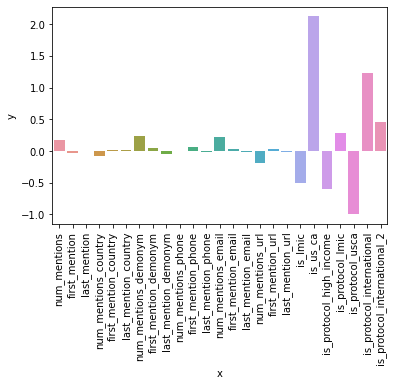

In [62]:
import seaborn as sns
sns.barplot(data=pd.DataFrame({"x":FEATURES, "y":m.coef_[0]}), x="x", y="y")
plt.xticks(rotation=90)
;

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
m = RandomForestClassifier()

In [65]:
m.fit(X_train, y_train)

RandomForestClassifier()

''

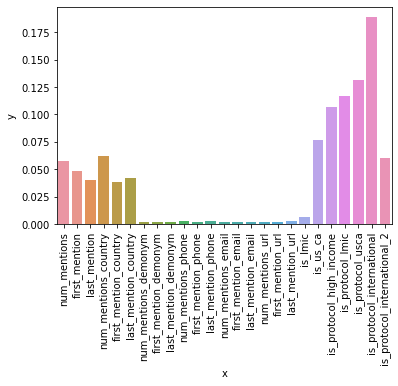

In [66]:
import seaborn as sns
sns.barplot(data=pd.DataFrame({"x":FEATURES, "y":m.feature_importances_}), x="x", y="y")
plt.xticks(rotation=90)
;

In [67]:
y_pred = m.predict(X_val)

In [68]:
accuracy_score(y_val, y_pred)

0.7883251500272777

In [69]:
for idx in range(len(y_val)):
    if y_val[idx] != y_pred[idx]:
        a, b, c = file_names_val[idx].split("_", 2)
        url = f"https://clinicaltrials.gov/ProvidedDocs/{a}/{b}/{c}"
        print (y_val[idx], y_pred[idx], countries_val[idx], url)


1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT02895100/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT02895100/Prot_000.pdf
1 0 AU https://clinicaltrials.gov/ProvidedDocs/00/NCT02895100/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT02895100/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT02895100/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT02895100/Prot_000.pdf
0 1 CH https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
0 1 CA https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
1 0 FR https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
1 0 XX https://clinicaltrials.gov/ProvidedDocs/00/NCT03823300/Prot_000.pdf
1 0 XX https://clinicaltr

''

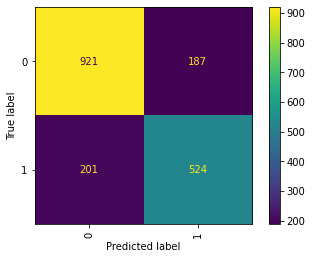

In [70]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.xticks(rotation=90)
;

In [71]:
y_pred_proba = m.predict_proba(X_val)[:,1]

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print (f"Countries ROC AUC {roc_auc} for ensemble model")


Countries ROC AUC 0.8652508402838293 for ensemble model


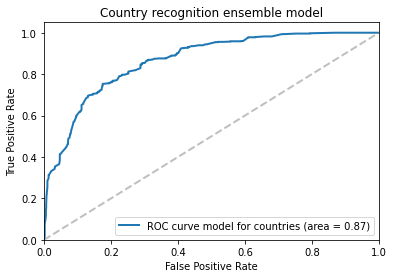

In [73]:
plt.figure()
lw = 2
    
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    # color="darkorange",
    lw=lw,
    label=f"ROC curve model for countries (area = {roc_auc:0.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Country recognition ensemble model")
plt.legend(loc="lower right")
plt.show()

In [74]:
import bz2, pickle as pkl
with bz2.open("../front_end/models/country_ensemble_model.pkl.bz2", "wb") as f:
    pkl.dump(m, f)